In [8]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [9]:
## read data
features = pd.read_csv('data_processed_3.csv') ## PCA applied Data
data = pd.read_csv('data_processed_2.csv') ## Data without PCA

In [10]:
## Splitting data into Features and Target
X = data.drop(['P_HABITABLE'], axis=1)
y = data["P_HABITABLE"]

In [11]:
col = X.columns

In [12]:
## Scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
X = pd.DataFrame(X, columns=col)

In [14]:
X

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,-1.731623,0.0,5.403340,-0.820246,0.574557,2.186428,-0.913427,0.589700,-1.947139,-1.212306,...,-0.228579,-0.187867,-0.267714,-1.370595,-0.867905,-0.886963,-2.143512,1.204373,6.054906,-0.043532
1,-1.730767,0.0,3.964870,-1.484357,1.057554,2.057056,-0.736512,0.472251,-1.407238,1.377996,...,-0.228579,-0.187867,-0.267714,-1.381600,2.077300,2.074938,-0.581674,1.231623,4.520055,-0.039651
2,-1.729911,0.0,0.896544,0.018261,-0.028514,1.495023,0.177824,-0.197329,-1.677188,-1.212306,...,-0.228579,-0.187867,-0.267714,-1.385513,-2.065955,-2.091804,-2.270148,1.346398,1.246143,-0.050971
3,-1.729056,0.0,0.853329,0.076304,-0.077490,1.102169,-0.023892,-0.035080,-3.296892,1.377996,...,-0.228579,-0.187867,-1.870829,-0.887322,-0.119124,-0.133937,-0.919369,1.349504,1.200032,-0.017012
4,-1.728200,0.0,-0.035683,0.122792,-0.111300,-0.723727,0.237347,-0.207016,-4.916596,1.377996,...,4.374849,5.322906,1.335401,0.870150,-0.568393,-0.585753,0.811316,1.452709,0.251454,-0.037549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,-0.709850,0.0,-0.553816,0.162860,-0.140345,-0.590528,0.714709,-0.239458,1.292269,2.016701,...,4.374849,-0.187867,1.335401,3.910202,2.177138,2.175342,1.106799,-0.689652,-0.330514,-0.062216
4044,-0.708994,0.0,-0.553816,0.162860,-0.140345,-0.402409,0.330174,-0.209629,1.292269,2.016701,...,-0.228579,-0.187867,-0.267714,0.832415,2.177138,2.175342,1.106799,-0.524594,-0.326481,-0.063459
4045,-1.621230,0.0,-0.583801,0.176234,-0.149697,-0.266898,0.237347,-0.266345,1.292269,2.034442,...,-0.228579,-0.187867,-0.267714,2.600464,-0.069206,-0.083736,0.009291,-0.831939,-0.333390,-0.064053
4046,-1.620375,0.0,-0.583442,0.176401,-0.149590,-0.266898,0.237347,-0.266345,1.292269,2.034442,...,4.374849,-0.187867,1.335401,4.885788,-0.069206,-0.083736,0.009291,-0.817926,-0.333007,-0.063826


In [22]:
## Lets take 7-fold cross validation
# it is with non-resampled data(raw data) 
kf = KFold(n_splits=7, shuffle=True, random_state=42)
fold_losses = []
fold_accuracies = []
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Looping over each fold
for train_index, test_index in kf.split(X):
    # Splitting the data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    # Training the model
    model.fit(X_train, y_train)
    # Evaluating the model
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    # Calculating loss
    fold_losses.append(log_loss(y_test, y_pred_proba))
    # Calculating accuracy
    fold_accuracies.append(accuracy_score(y_test, y_pred))
# Storing the average loss and accuracy for this value of K
losses.append(np.mean(fold_losses))
accuracies.append(np.mean(fold_accuracies))

In [24]:
## Random Forest classifier
accuracy = np.mean(accuracies)
loss = np.mean(losses)
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

Accuracy: 0.9965141342611984
Loss: 0.011689081237742677


In [25]:
y_pred_proba

array([[1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.99, 0.  , 0.01],
       ...,
       [1.  , 0.  , 0.  ],
       [0.71, 0.26, 0.03],
       [1.  , 0.  , 0.  ]])

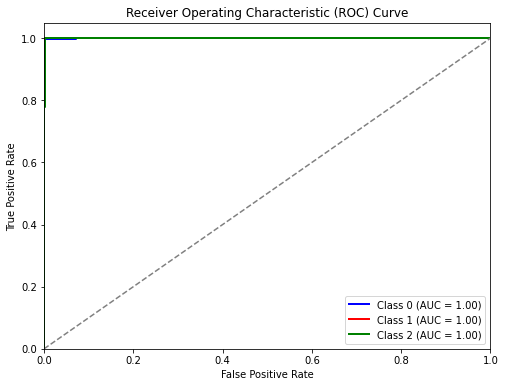

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x432 with 0 Axes>

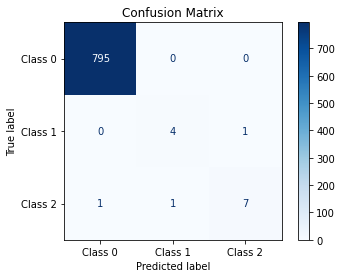

In [28]:
# Computing ROC curve and ROC area for each class
## RANDOM FOREST
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
            label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, display_labels=["Class 0", "Class 1", "Class 2"])
plt.title('Confusion Matrix')
plt.show()

In [15]:
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42) ## Stratified K-Fold Cross Validation
clf = RandomForestClassifier(n_estimators=100, random_state=42) ## Normal Random Forest Classifier

In [16]:
# Convert target labels to binary format
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

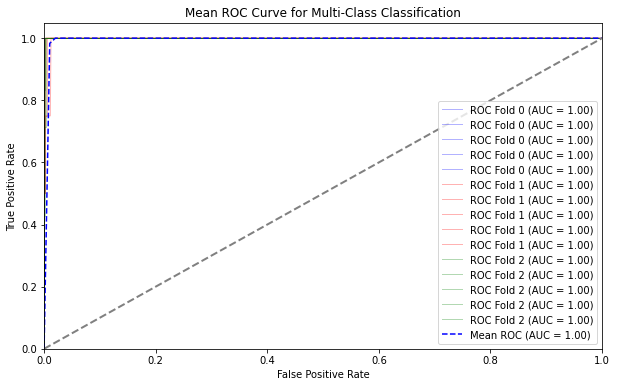

In [42]:
# Create a figure for ROC curves
plt.figure(figsize=(10, 6))
# Initialize variables to store mean TPR and AUC
mean_tpr = 0.0
mean_auc = 0.0
# Set up colors for plotting
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    tprs = []
    aucs = []
    for train, test in skf.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y_bin[train, i], y_bin[test, i]
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, color=color, alpha=0.3,
                label='ROC Fold %d (AUC = %0.2f)' % (i, roc_auc))

    mean_tpr += np.mean(tprs, axis=0)
    mean_auc += np.mean(aucs)

# Plot the mean ROC curve
mean_tpr /= n_classes
mean_auc /= n_classes
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--',
        label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

In [44]:
## Hyper-parameter Optimization of RF using GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20]
}
# Initialize the modelto 
model = RandomForestClassifier(random_state=42)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# Fit the data to GridSearchCV
grid_search.fit(X, y)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
0.9967885974148849
RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)
1
<function _passthrough_scorer at 0x000001AC578979A0>
5
0.732973575592041
{'mean_fit_time': array([0.60572438, 1.08939776, 1.65237432, 2.17138457, 2.65973468,
       0.54841051, 1.05107145, 2.51420813, 5.22160144, 7.2039331 ,
       1.41925406, 3.06153994, 3.67888575, 4.52731204, 5.47971258,
       1.10382309, 2.06002522, 3.18478937, 4.26676621, 5.18069925,
       1.00685244, 1.91320233, 2.90476975, 3.89713335, 4.89558992,
       1.02583585, 1.90582242, 2.83704119, 3.83854795, 4.76608467,
       0.93522668, 1.82711692, 2.73532667, 3.69602056, 4.76744938,
       0.96675568, 1.87328634, 2.83165321, 3.69768143, 4.54795694,
       0.88807535, 1.75326152, 2.64385586, 3.45304475, 4.42381501,
       0.90164933, 1.81525307, 2.69514999, 3.53246946, 4.25248151,
       0.88434658, 1.7

In [45]:
# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_index_)
print(grid_search.scorer_)
print(grid_search.n_splits_)
print(grid_search.refit_time_)
print(grid_search.cv_results_)
print(grid_search.multimetric_)
print(grid_search.best_estimator_.feature_importances_)
print(grid_search.best_estimator_.predict_proba(X))

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
0.9967885974148849
RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)
1
<function _passthrough_scorer at 0x000001AC578979A0>
5
0.732973575592041
{'mean_fit_time': array([0.60572438, 1.08939776, 1.65237432, 2.17138457, 2.65973468,
       0.54841051, 1.05107145, 2.51420813, 5.22160144, 7.2039331 ,
       1.41925406, 3.06153994, 3.67888575, 4.52731204, 5.47971258,
       1.10382309, 2.06002522, 3.18478937, 4.26676621, 5.18069925,
       1.00685244, 1.91320233, 2.90476975, 3.89713335, 4.89558992,
       1.02583585, 1.90582242, 2.83704119, 3.83854795, 4.76608467,
       0.93522668, 1.82711692, 2.73532667, 3.69602056, 4.76744938,
       0.96675568, 1.87328634, 2.83165321, 3.69768143, 4.54795694,
       0.88807535, 1.75326152, 2.64385586, 3.45304475, 4.42381501,
       0.90164933, 1.81525307, 2.69514999, 3.53246946, 4.25248151,
       0.88434658, 1.79331632, 2.71190062, 3.65073576, 4.33095574,
       0.878866  ,

In [17]:
## Resampling the data
## This is important because the data is highly imbalanced
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the resampling method
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# Apply resampling to the feature matrix X and target labels y
X_resampled, y_resampled = over_sampler.fit_resample(X, y)
X_resampled, y_resampled = under_sampler.fit_resample(X_resampled, y_resampled)

In [18]:
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.Series(y_resampled)

In [19]:
X_resampled.shape, y_resampled.shape ## Oversampled data

((11979, 104), (11979,))

In [25]:
# Define the range of K values from k=2 to k=10 for K-Fold Cross Validation
## Random Forest
k_values = range(2, 11)

# Initialize lists to store results
losses = []
accuracies = []

# Loop over different K values
for k in k_values:
    print(f"K-Fold Cross Validation with K = {k}")
    # Initialize K-Fold Cross Validator
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_losses = []
    fold_accuracies = []
    # Looping over each fold
    for train_index, test_index in kf.split(X):
        # Splitting the data into train and test sets
        X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]    
        # Training the model
        model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=5, min_samples_split=2)
        model.fit(X_train, y_train)
        # Evaluating the model
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        # Calculating loss
        fold_losses.append(log_loss(y_test, y_pred_proba))
        # Calculating accuracy
        fold_accuracies.append(accuracy_score(y_test, y_pred))
    # Storing the average loss and accuracy for this value of K
    losses.append(np.mean(fold_losses))
    accuracies.append(np.mean(fold_accuracies))

K-Fold Cross Validation with K = 2
K-Fold Cross Validation with K = 3
K-Fold Cross Validation with K = 4
K-Fold Cross Validation with K = 5
K-Fold Cross Validation with K = 6
K-Fold Cross Validation with K = 7
K-Fold Cross Validation with K = 8
K-Fold Cross Validation with K = 9
K-Fold Cross Validation with K = 10


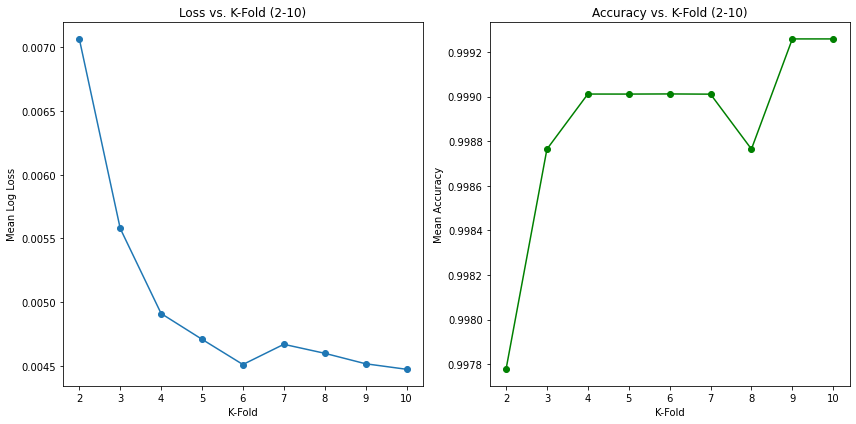

In [26]:
# Plot loss versus K values
## Random forest
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, losses, marker='o')
plt.title('Loss vs. K-Fold (2-10)')
plt.xlabel('K-Fold')
plt.ylabel('Mean Log Loss')

# Plot accuracy versus K values
plt.subplot(1, 2, 2)
plt.plot(k_values, accuracies, marker='o', color='green')
plt.title('Accuracy vs. K-Fold (2-10)')
plt.xlabel('K-Fold')
plt.ylabel('Mean Accuracy')

plt.tight_layout()
plt.show()

In [20]:
# Defining the range of K values from k=2 to k=10 for K-Fold Cross Validation
## XGBoost
k_values = range(2, 11)

# Initialize=ing lists to store results
losses = []
accuracies = []

# Looping over different K values
for k in k_values:
    print(f"K-Fold Cross Validation with K = {k}")
    # Initialize K-Fold Cross Validator
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_losses = []
    fold_accuracies = []
    # Looping over each fold
    for train_index, test_index in kf.split(X):
        # Splitting the data into train and test sets
        X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]    
        # Training the model
        model = XGBClassifier(n_estimators=100, random_state=42, max_depth=5)
        model.fit(X_train, y_train)
        # Evaluating the model
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        # Calculating loss
        fold_losses.append(log_loss(y_test, y_pred_proba))
        # Calculating accuracy
        fold_accuracies.append(accuracy_score(y_test, y_pred))
    # Storing the average loss and accuracy for this value of K
    losses.append(np.mean(fold_losses))
    accuracies.append(np.mean(fold_accuracies))

K-Fold Cross Validation with K = 2
K-Fold Cross Validation with K = 3
K-Fold Cross Validation with K = 4
K-Fold Cross Validation with K = 5
K-Fold Cross Validation with K = 6
K-Fold Cross Validation with K = 7
K-Fold Cross Validation with K = 8
K-Fold Cross Validation with K = 9
K-Fold Cross Validation with K = 10


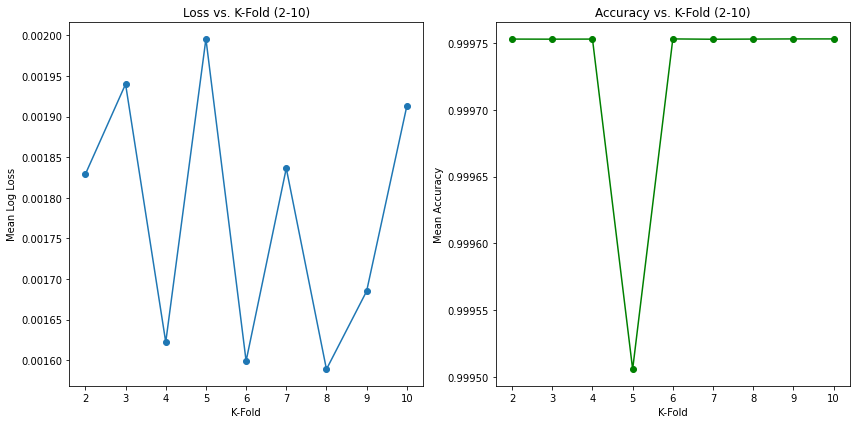

In [21]:
# Plot loss versus K values
## XGBoost 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, losses, marker='o')
plt.title('Loss vs. K-Fold (2-10)')
plt.xlabel('K-Fold')
plt.ylabel('Mean Log Loss')

# Plot accuracy versus K values
plt.subplot(1, 2, 2)
plt.plot(k_values, accuracies, marker='o', color='green')
plt.title('Accuracy vs. K-Fold (2-10)')
plt.xlabel('K-Fold')
plt.ylabel('Mean Accuracy')

plt.tight_layout()
plt.show()

In [27]:
## Best Random Forest Classifier 
rf_best = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=5, min_samples_split=2)
## Best XGBoost Classifier 
xgb_best = XGBClassifier(n_estimators=100, random_state=42, max_depth=5, min_samples_split=2)

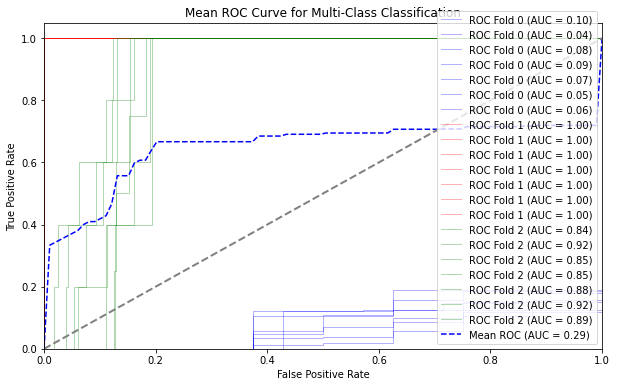

In [41]:
# Create a figure for ROC curves
plt.figure(figsize=(10, 6))
n_classes = 3
# Initialize variables to store mean TPR and AUC
## We have to take this one
mean_tpr = 0.0
mean_auc = 0.0
# Set up colors for plotting
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = 0.0
    for train, test in skf.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y_bin[train, i], y_bin[test, i]
        X_resampled, y_resampled = over_sampler.fit_resample(X, y)
        X_resampled, y_resampled = under_sampler.fit_resample(X_resampled, y_resampled)
        rf_best.fit(X_resampled, y_resampled)
        y_prob = rf_best.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        tprs.append(np.interp(mean_fpr , fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, color=color, alpha=0.3,
                label='ROC Fold %d (AUC = %0.2f)' % (i, roc_auc))

    mean_tpr += np.mean(tprs, axis=0)
    mean_auc += np.mean(aucs)

# Plot the mean ROC curve
mean_tpr /= n_classes
mean_auc /= n_classes
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--',
        label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x432 with 0 Axes>

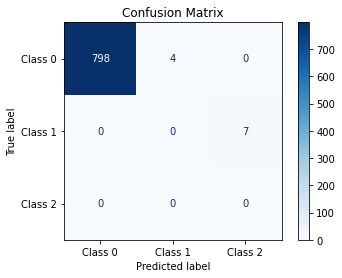

In [58]:
## print the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=["Class 0", "Class 1", "Class 2"])
plt.title('Confusion Matrix')
plt.show()

In [62]:
y_resampled.value_counts()

P_HABITABLE
0.0    3993
1.0    3993
2.0    3993
Name: count, dtype: int64

In [64]:
y_pred = clf.predict(X_test) ## RF
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.4%}".format(acc))
print(classification_report(y_test, y_pred))

Accuracy: 98.6403%
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       802
         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00         0

    accuracy                           0.99       809
   macro avg       0.33      0.33      0.33       809
weighted avg       0.99      0.99      0.99       809



c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [12]:
## 7 fold cross validation using random forest and calculating the cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

In [13]:
y_pred = rf_best.predict(X_test) ## RF_Best classifier
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.4%}".format(acc))
print(classification_report(y_test, y_pred))

Accuracy: 99.7913%
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       798
         1.0       1.00      1.00      1.00       801
         2.0       0.99      1.00      1.00       797

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396



In [14]:
## cross validation score
scores = cross_val_score(clf_best, X_resampled, y_resampled, cv=7)
print("Cross Validation Score: {:.4%} (+/- {:.4%})".format(scores.mean(), scores.std() * 2))

Cross Validation Score: 99.8330% (+/- 0.3272%)


In [26]:
# XGBoost gives best accuracy with 7 fold cross validation
## Now hyper parameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 1000],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15]
}
# Initialize the modelto 
model = XGBClassifier(random_state=42)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# Fit the data to GridSearchCV
grid_search.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[15:21:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [100, 200, 300, 400, 500, 1000]},
             verbose=2)

In [27]:
# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_index_)
print(grid_search.scorer_)
print(grid_search.n_splits_)
print(grid_search.refit_time_)
print(grid_search.cv_results_)
print(grid_search.multimetric_)
print(grid_search.best_estimator_.feature_importances_)
print(grid_search.best_estimator_.predict_proba(X))

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.9980237757328817
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
0
<function _passthrough_scorer at 0x00000241821EDFC0>
5
1.1850650310516357
{'mean_fit_time': array([ 3.57615476,  4.69192648,  5.76564097,  9.07228684, 12.

In [51]:
## best xgb classifier
xgb_best = XGBClassifier(n_estimators=100, random_state=42, max_depth=5, min_samples_split=2)

In [55]:
## 7 fold cross validation using XGBoost and calculating the cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
xgb_best.fit(X_train, y_train)

[20:02:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [56]:
y_pred = xgb_best.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.4%}".format(acc))
print(classification_report(y_test, y_pred))
## printing the results

Accuracy: 99.9583%
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       798
         1.0       1.00      1.00      1.00       801
         2.0       1.00      1.00      1.00       797

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396



In [41]:
X_resampled.shape, y_resampled.shape

((11979, 104), (11979,))

In [54]:
## cross validation score
scores = cross_val_score(xgb_best, X_resampled, y_resampled, cv=7)
print("Cross Validation Score: {:.4%} (+/- {:.4%})".format(scores.mean(), scores.std() * 2))

[19:55:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:55:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:55:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:55:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[19:55:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "m

In [ ]:
## Cross validation scores and accuracy
## For Random forest with 7 fold cross validation, score = 99.8330 (+/- 0.3389%)
## For XGBoost classifer with 7 fold, cross validation, score = 99.9833% (+/- 0.0818%)
## For XGBoost classifer with 7 fold, cross validation, with PCA with 80 components score = 99.8664% (+/- 0.1204%)
## For RF Classifier, accuracy = 99.7913%
## For XGB Classifier, accuracy = 99.9583%

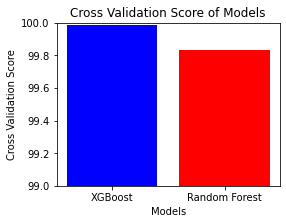

In [22]:
x = ["XGBoost", "Random Forest"]
y = [99.9833, 99.8330] 
plt.figure(figsize=(4, 3))
plt.bar(x, y, color=['blue', 'red'])
plt.xlabel("Models")
plt.ylabel("Cross Validation Score")
plt.title("Cross Validation Score of Models")
plt.ylim(99.0, 100)
plt.show()